In [6]:
import torch.nn as nn
import os
import utils
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color, data, restoration, exposure
from scipy.linalg import circulant
from scipy.sparse import diags
from scipy.signal import convolve2d as conv2
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import utils
import pyro
from torch.distributions import constraints
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import math
import os
import torch
import torch.distributions.constraints as constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from scipy.linalg import circulant
from pyro.ops.tensor_utils import convolve
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)



In [7]:
psf_w, psf_h, sigma, scale = 64, 64, 1, 4  # Constants
stop_loss = 1e-2
step_size = 20 * stop_loss / 3.0

astro = (rescale(color.rgb2gray(data.astronaut()), 1.0 / scale)
         * 2**16).astype(int)  # Raw image
psf = np.zeros((psf_w, psf_h))
psf[psf_w // 2, psf_h // 2] = 1
psf = gaussian_filter(psf, sigma=sigma)  # PSF

astro_blur = conv2(astro, psf, "same")  # Blur image
# astro_blur = np.random.poisson(astro_blur)

y = torch.tensor(astro_blur.flatten()).int()

In [8]:
# Function for making circulant matrix because I've not gotten conv2d in torch to work.

H, rolled_psf = utils.make_circulant_from_cropped_psf(
    psf, (psf_w, psf_h), astro.shape
)  # Get H

f = np.asarray(np.matrix(astro_blur.flatten()).transpose()).reshape(
    (-1,)
)  # f is the recorded image
x_0 = np.asarray(np.matmul(H.transpose(), f)).reshape(
    (-1,)
)  # x0 is the initial guess image

# Torch them

H_torch = torch.tensor(
    H, dtype=torch.float
).to_sparse()  # This is sparse, utterlly full of zeros, speeds everything up
b_torch = torch.tensor(f, dtype=torch.float)
x_torch = torch.tensor(
    x_0, requires_grad=True, dtype=torch.float
)  # Requires grad is magic

# print('Loss before: %s' % (torch.norm(torch.matmul(H_torch, x_torch) - b_torch)))


class HTorch(nn.Module):
    def __init__(self, H):
        super(HTorch, self).__init__()
        self.H = H
        # self.x_0 = x_0
        # self.x = torch.nn.Linear(H.shape[0], 1)
        self.x = torch.nn.Parameter(x_torch)

    def forward(self):
        return torch.matmul(H_torch, self.x).double()


model = HTorch(H_torch)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1000)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
pbar=tqdm(range(100))
for t in pbar:
    y_pred = model()
    loss = loss_fn(y_pred, y.double())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_postfix({"loss":f'{loss:.2f}'})
    # scheduler.step(loss)
    # print(optimizer.state_dict()["param_groups"][0]["lr"])
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(0, torch.inf)


  0%|          | 0/100 [00:00<?, ?it/s]

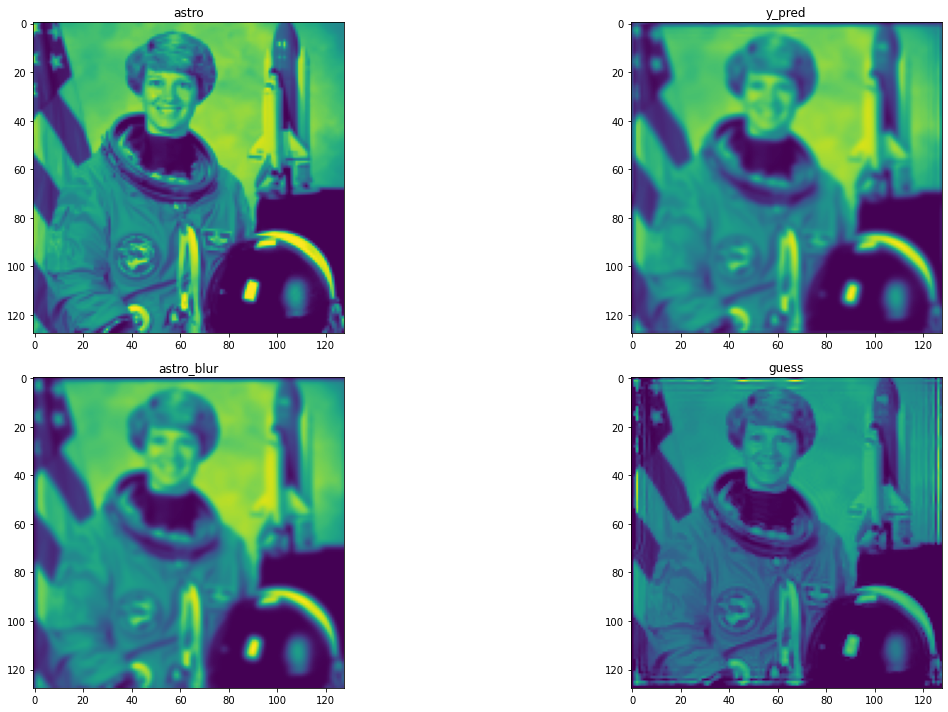

In [9]:

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(astro).axes.set_title("astro")
ax[1, 0].imshow(astro_blur).axes.set_title("astro_blur")
# ax[0].imshow(y.reshape(astro.shape)).set_title("y_true")
ax[0, 1].imshow(y_pred.detach().numpy().reshape(
    astro.shape)).axes.set_title("y_pred")
ax[1, 1].imshow(model.x.detach().numpy().reshape(
    astro.shape)).axes.set_title("guess")
plt.tight_layout()
plt.show()

In [10]:

# y = (H*x)+n
# @pyro.condition(data={"Hx": y})


def model(y, H):
    x = pyro.param("x", torch.tensor(x_0).float(),
                   constraint=constraints.positive)
    Hx = torch.matmul(H, x).float()
    pyro.sample("f", dist.Poisson(Hx).to_event(1), obs=y)

# MLE means we can ignore the guide function
# MAP would mean that the guide (prior/posteri?) would be a delta function


def guide(y, H):
    pass

# def guide(y,H):
#     f_map = pyro.param("f_map", torch.tensor(0.5),
#                        constraint=constraints.unit_interval)
#     pyro.sample("latent_fairness", dist.Delta(f_map))

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
# https://en.wikipedia.org/wiki/Evidence_lower_bound
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

loss = []
pyro.clear_param_store()
n_steps = 100
pbar = tqdm(range(n_steps))
for step in pbar:
    loss.append(svi.step(y.int(), torch.tensor(H).float()))
    pbar.set_postfix({"loss":f'{loss[-1]:.2f}'})
    # print(loss[-1])


fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(astro).axes.set_title("astro")
ax[1, 0].imshow(astro_blur).axes.set_title("astro_blur")
# ax[0].imshow(y.reshape(astro.shape)).set_title("y_true")
ax[0, 1].imshow(y_pred.detach().numpy().reshape(astro.shape)).axes.set_title("y_pred")
ax[1, 1].imshow(pyro.param("x").detach().numpy().reshape(astro.shape)).axes.set_title("guess")
plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]